In [78]:
coco_idx_to_label = {0 :"person",
1 :"bicycle",
2 :"car",
3 :"motorcycle",
4 :"airplane",
5 :"bus",
6 :"train",
7 :"truck",
8 :"boat",
9 :"traffic light",
10: "fire hydrant",
11: "stop sign",
12: "parking meter",
13: "bench",
14: "bird",
15: "cat",
16: "dog",
17: "horse",
18: "sheep",
19: "cow",
20: "elephant",
21: "bear",
22: "zebra",
23: "giraffe",
24: "backpack",
25: "umbrella",
26: "handbag",
27: "tie",
28: "suitcase",
29: "frisbee",
30: "skis",
31: "snowboard",
32: "sports ball",
33: "kite",
34: "baseball bat",
35: "baseball glove",
36: "skateboard",
37: "surfboard",
38: "tennis racket",
39: "bottle",
40: "wine glass",
41: "cup",
42: "fork",
43: "knife",
44: "spoon",
45: "bowl",
46: "banana",
47: "apple",
48: "sandwich",
49: "orange",
50: "broccoli",
51: "carrot",
52: "hot dog",
53: "pizza",
54: "donut",
55: "cake",
56: "chair",
57: "couch",
58: "potted plant",
59: "bed",
60: "dining table",
61: "toilet",
62: "tv",
63: "laptop",
64: "mouse",
65: "remote",
66: "keyboard",
67: "cell phone",
68: "microwave",
69: "oven",
70: "toaster",
71: "sink",
72: "refrigerator",
73: "book",
74: "clock",
75: "vase",
76: "scissors",
77: "teddy bear",
78: "hair drier",
79: "toothbrush",}

In [79]:
import hashlib
import torch
from utils.dataloaders import create_dataloader
from utils.general import (LOGGER, TQDM_BAR_FORMAT, check_amp, check_dataset, check_file, check_git_info,
                           check_git_status, check_img_size, check_requirements, check_suffix, check_yaml, colorstr,
                           get_latest_run, increment_path, init_seeds, intersect_dicts, labels_to_class_weights,
                           labels_to_image_weights, methods, one_cycle, print_args, print_mutation, strip_optimizer,
                           yaml_save)
from torch.utils.data import DataLoader, Dataset, dataloader, distributed
from tqdm import tqdm
import matplotlib.pyplot as plt
import math
from multiprocessing.pool import Pool, ThreadPool
import os
from pathlib import Path
from utils.loss import ComputeLoss
from itertools import repeat
import random
import torchvision
from utils.general import (DATASETS_DIR, LOGGER, NUM_THREADS, TQDM_BAR_FORMAT, check_dataset, check_requirements,
                           check_yaml, clean_str, cv2, is_colab, is_kaggle, segments2boxes, unzip_file, xyn2xy,
                           xywh2xyxy, xywhn2xyxy, xyxy2xywhn)
from utils.augmentations import (Albumentations, augment_hsv, classify_albumentations, classify_transforms, copy_paste,
                                 letterbox, mixup, random_perspective)
import numpy as np
from models.yolo import Model

def show_image(image, label=None):
    if label != None:
        boxes = torchvision.ops.box_convert(boxes=label[:,2:] * 640, in_fmt="cxcywh", out_fmt="xyxy")
        classes = []
        for obj in label:
            class_idx = int(obj[1].item())
            classes.append(coco_idx_to_label[class_idx])
        image = torchvision.utils.draw_bounding_boxes(image, boxes, labels=classes, colors="red", width=2, font_size=400)
    image = image.permute(1, 2, 0)
    plt.imshow(image.squeeze())
    #plt.title(f'Label: {label}')
    plt.show()



In [80]:
train_path = "/Users/maksimgaiduk/repos/datasets/coco/train2017.txt"
val_path = "/Users/maksimgaiduk/repos/datasets/coco/val2017.txt"
imgsz = 640
batch_size = 4
WORLD_SIZE = 1
gs = 32 # grid size, aka max stride
single_cls = False
hyp = {
    "lr0": 0.01,
    "lrf": 0.01,
    "momentum": 0.937,
    "weight_decay": 0.001,
    "warmup_epochs": 3.0,
    "warmup_momentum": 0.8,
    "warmup_bias_lr": 0.1,
    "box": 0.05,
    "cls": 0.5,
    "cls_pw": 1.0,
    "obj": 1.0,
    "obj_pw": 1.0,
    "iou_t": 0.2,
    "anchor_t": 4.0,
    "fl_gamma": 0.0,
    "hsv_h": 0.015,
    "hsv_s": 0.7,
    "hsv_v": 0.4,
    "degrees": 0.0,
    "translate": 0.1,
    "scale": 0.5,
    "shear": 0.0,
    "perspective": 0.0,
    "flipud": 0.0,
    "fliplr": 0.5,
    "mosaic": 1.0,
    "mixup": 0.0,
    "copy_paste": 0.0
}
cfg = "/Users/maksimgaiduk/repos/yolov5/models/yolov5n.yaml"
cache = None
rect = False # rectangular training
LOCAL_RANK = -1
workers = 8
image_weights = False
quad = False
seed = 0

# device
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
#device = "cpu"

In [81]:
train_loader, dataset = create_dataloader(train_path,
      imgsz,
      batch_size // WORLD_SIZE,
      gs,
      single_cls,
      hyp=hyp,
      augment=True,
      cache=cache,
      rect=rect,
      rank=LOCAL_RANK,
      workers=workers,
      image_weights=image_weights,
      quad=quad,
      prefix=colorstr('train: '),
      shuffle=True,
      seed=seed)

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))
train: Scanning /Users/maksimgaiduk/repos/datasets/coco/train2017.cache... 117266 images, 1021 backgrounds, 0 corrupt: 100%|██████████| 118287/118287 [00:00<?, ?it/s]
train: WARNING ⚠️ /Users/maksimgaiduk/repos/datasets/coco/images/train2017/000000099844.jpg: 2 duplicate labels removed
train: WARNING ⚠️ /Users/maksimgaiduk/repos/datasets/coco/images/train2017/000000201706.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /Users/maksimgaiduk/repos/datasets/coco/images/train2017/000000214087.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /Users/maksimgaiduk/repos/datasets/coco/images/train2017/000000522365.jpg: 1 duplicate labels removed


torch.Size([3, 640, 640])
torch.Size([8, 6])


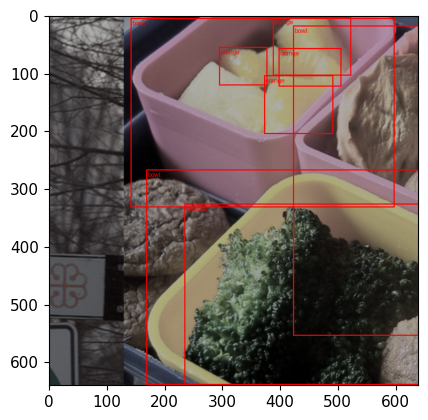

In [82]:
%matplotlib inline
x1, y1, path, _ = dataset[0]
print(x1.shape) # 3x640x640
print(y1.shape) # n_obj*6: 
show_image(x1, y1)

In [83]:
for X, y, paths, _ in train_loader:
    break
# y is of shape number_objs*6
# 6: image_index, class_index, x, y, w, h
X.shape, y.shape

(torch.Size([4, 3, 640, 640]), torch.Size([43, 6]))

In [84]:
paths[0]


'/Users/maksimgaiduk/repos/datasets/coco/images/train2017/000000152397.jpg'

In [85]:
y.shape, y

(torch.Size([43, 6]),
 tensor([[0.00000e+00, 5.30000e+01, 3.96669e-01, 4.79963e-01, 7.93338e-01, 5.88065e-01],
         [0.00000e+00, 0.00000e+00, 3.21526e-01, 2.12996e-01, 6.43052e-01, 1.67260e-01],
         [0.00000e+00, 6.00000e+01, 4.20099e-01, 4.96443e-01, 8.40199e-01, 5.63289e-01],
         [0.00000e+00, 0.00000e+00, 9.74390e-01, 5.39114e-01, 5.12177e-02, 4.69156e-01],
         [0.00000e+00, 0.00000e+00, 6.21530e-01, 9.94613e-01, 2.69818e-02, 1.07708e-02],
         [0.00000e+00, 0.00000e+00, 2.17510e-01, 9.92081e-01, 7.67630e-02, 1.58359e-02],
         [0.00000e+00, 6.00000e+00, 3.75330e-01, 8.92184e-01, 7.50660e-01, 2.15629e-01],
         [0.00000e+00, 6.00000e+00, 7.81094e-01, 9.86248e-01, 7.03293e-02, 2.75012e-02],
         [0.00000e+00, 0.00000e+00, 9.27958e-01, 8.12408e-01, 3.07235e-02, 6.00933e-02],
         [1.00000e+00, 2.00000e+00, 7.97004e-02, 1.97181e-01, 1.59401e-01, 1.82715e-01],
         [1.00000e+00, 5.60000e+01, 2.62364e-01, 5.22728e-01, 1.61806e-01, 2.79334e-01],

In [86]:
X[0]

tensor([[[135, 135, 135,  ..., 135, 135, 135],
         [135, 135, 135,  ..., 135, 135, 135],
         [135, 135, 135,  ..., 135, 135, 135],
         ...,
         [142, 135, 131,  ..., 226, 201, 208],
         [150, 148, 131,  ..., 193, 177, 176],
         [137, 139, 126,  ..., 176, 150, 139]],

        [[135, 135, 135,  ..., 135, 135, 135],
         [135, 135, 135,  ..., 135, 135, 135],
         [135, 135, 135,  ..., 135, 135, 135],
         ...,
         [140, 134, 130,  ..., 226, 201, 208],
         [141, 140, 126,  ..., 193, 177, 176],
         [125, 125, 111,  ..., 176, 150, 139]],

        [[135, 135, 135,  ..., 135, 135, 135],
         [135, 135, 135,  ..., 135, 135, 135],
         [135, 135, 135,  ..., 135, 135, 135],
         ...,
         [146, 140, 136,  ..., 226, 201, 208],
         [147, 147, 133,  ..., 193, 177, 176],
         [130, 133, 123,  ..., 176, 150, 139]]], dtype=torch.uint8)

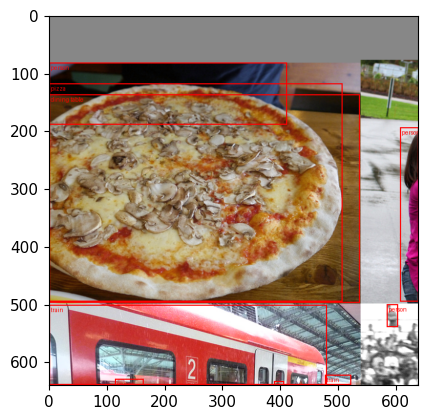

In [87]:
show_image(X[0], y[:9])
# eop

In [88]:
val_loader = create_dataloader(val_path,
    imgsz,
    batch_size // WORLD_SIZE * 2,
    gs,
    single_cls,
    hyp=hyp,
    cache=None,
    rect=True,
    rank=-1,
    workers=workers * 2,
    pad=0.5,
    prefix=colorstr('val: '))[0]

val: Scanning /Users/maksimgaiduk/repos/datasets/coco/val2017.cache... 4952 images, 48 backgrounds, 0 corrupt: 100%|██████████| 5000/5000 [00:00<?, ?it/s]


In [89]:
data = "/Users/maksimgaiduk/repos/yolov5/data/coco.yaml"
data_dict = check_dataset(data)
data_dict

{'path': PosixPath('/Users/maksimgaiduk/repos/datasets/coco'),
 'train': '/Users/maksimgaiduk/repos/datasets/coco/train2017.txt',
 'val': '/Users/maksimgaiduk/repos/datasets/coco/val2017.txt',
 'test': '/Users/maksimgaiduk/repos/datasets/coco/test-dev2017.txt',
 'names': {0: 'person',
  1: 'bicycle',
  2: 'car',
  3: 'motorcycle',
  4: 'airplane',
  5: 'bus',
  6: 'train',
  7: 'truck',
  8: 'boat',
  9: 'traffic light',
  10: 'fire hydrant',
  11: 'stop sign',
  12: 'parking meter',
  13: 'bench',
  14: 'bird',
  15: 'cat',
  16: 'dog',
  17: 'horse',
  18: 'sheep',
  19: 'cow',
  20: 'elephant',
  21: 'bear',
  22: 'zebra',
  23: 'giraffe',
  24: 'backpack',
  25: 'umbrella',
  26: 'handbag',
  27: 'tie',
  28: 'suitcase',
  29: 'frisbee',
  30: 'skis',
  31: 'snowboard',
  32: 'sports ball',
  33: 'kite',
  34: 'baseball bat',
  35: 'baseball glove',
  36: 'skateboard',
  37: 'surfboard',
  38: 'tennis racket',
  39: 'bottle',
  40: 'wine glass',
  41: 'cup',
  42: 'fork',
  43: 'kn

In [90]:
# number of classes
nc = int(data_dict['nc'])
nc

80

In [91]:
model = Model(cfg, ch=3, nc=nc, anchors=hyp.get('anchors')).to(device)


                 from  n    params  module                                  arguments                     
  0                -1  1      1760  models.common.Conv                      [3, 16, 6, 2, 2]              
  1                -1  1      4672  models.common.Conv                      [16, 32, 3, 2]                
  2                -1  1      4800  models.common.C3                        [32, 32, 1]                   
  3                -1  1     18560  models.common.Conv                      [32, 64, 3, 2]                
  4                -1  2     29184  models.common.C3                        [64, 64, 2]                   
  5                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  6                -1  3    156928  models.common.C3                        [128, 128, 3]                 
  7                -1  1    295424  models.common.Conv                      [128, 256, 3, 2]              
  8                -1  1    296448  

 20                -1  1     74496  models.common.C3                        [128, 128, 1, False]          
 21                -1  1    147712  models.common.Conv                      [128, 128, 3, 2]              
 22          [-1, 10]  1         0  models.common.Concat                    [1]                           
 23                -1  1    296448  models.common.C3                        [256, 256, 1, False]          
 24      [17, 20, 23]  1    115005  models.yolo.Detect                      [80, [[10, 13, 16, 30, 33, 23], [30, 61, 62, 45, 59, 119], [116, 90, 156, 198, 373, 326]], [64, 128, 256]]
YOLOv5n summary: 214 layers, 1872157 parameters, 1872157 gradients, 4.6 GFLOPs



In [92]:
len(model.model), model.model

(25,
 Sequential(
   (0): Conv(
     (conv): Conv2d(3, 16, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2), bias=False)
     (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
     (act): SiLU(inplace=True)
   )
   (1): Conv(
     (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
     (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
     (act): SiLU(inplace=True)
   )
   (2): C3(
     (cv1): Conv(
       (conv): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
       (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
       (act): SiLU(inplace=True)
     )
     (cv2): Conv(
       (conv): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
       (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
       (act): SiLU(inplace=True)
     )
     (cv3): Conv(
       (conv): Conv2d(32, 32,

In [93]:
X = X.to(device).float() / 255
print(X.shape)
preds = model(X)
len(preds)

torch.Size([4, 3, 640, 640])


3

In [94]:
preds[0].shape, preds[1].shape, preds[2].shape

(torch.Size([4, 3, 80, 80, 85]),
 torch.Size([4, 3, 40, 40, 85]),
 torch.Size([4, 3, 20, 20, 85]))

In [95]:
x1 = model.model[0](X)
print(x1.shape)
model.model[0]

torch.Size([4, 16, 320, 320])


Conv(
  (conv): Conv2d(3, 16, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2), bias=False)
  (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
  (act): SiLU(inplace=True)
)

In [96]:
x2 = model.model[1](x1)
print(x2.shape)
model.model[1]

torch.Size([4, 32, 160, 160])


Conv(
  (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
  (act): SiLU(inplace=True)
)

In [97]:
x3 = model.model[2](x2)
print(x3.shape)
model.model[2]

torch.Size([4, 32, 160, 160])


C3(
  (cv1): Conv(
    (conv): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
    (act): SiLU(inplace=True)
  )
  (cv2): Conv(
    (conv): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
    (act): SiLU(inplace=True)
  )
  (cv3): Conv(
    (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
    (act): SiLU(inplace=True)
  )
  (m): Sequential(
    (0): Bottleneck(
      (cv1): Conv(
        (conv): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (cv2): Conv(
        (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1,

In [98]:
x4 = model.model[3](x3)
print(x4.shape)
model.model[3]

torch.Size([4, 64, 80, 80])


Conv(
  (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
  (act): SiLU(inplace=True)
)

In [99]:
x5 = model.model[4](x4)
print(x5.shape)
model.model[4]

torch.Size([4, 64, 80, 80])


C3(
  (cv1): Conv(
    (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
    (act): SiLU(inplace=True)
  )
  (cv2): Conv(
    (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
    (act): SiLU(inplace=True)
  )
  (cv3): Conv(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
    (act): SiLU(inplace=True)
  )
  (m): Sequential(
    (0): Bottleneck(
      (cv1): Conv(
        (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (cv2): Conv(
        (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1,

In [100]:
x6 = model.model[5](x5)
print(x6.shape)
model.model[5]

torch.Size([4, 128, 40, 40])


Conv(
  (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
  (act): SiLU(inplace=True)
)

In [101]:
x7 = model.model[6](x6)
print(x7.shape)
model.model[6]

torch.Size([4, 128, 40, 40])


C3(
  (cv1): Conv(
    (conv): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
    (act): SiLU(inplace=True)
  )
  (cv2): Conv(
    (conv): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
    (act): SiLU(inplace=True)
  )
  (cv3): Conv(
    (conv): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
    (act): SiLU(inplace=True)
  )
  (m): Sequential(
    (0): Bottleneck(
      (cv1): Conv(
        (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (cv2): Conv(
        (conv): Conv2d(64, 64, kernel_size=(3, 3), strid

In [102]:
x8 = model.model[7](x7)
print(x8.shape)
model.model[7]

torch.Size([4, 256, 20, 20])


Conv(
  (conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn): BatchNorm2d(256, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
  (act): SiLU(inplace=True)
)

In [103]:
x9 = model.model[8](x8)
print(x9.shape)
model.model[8]

torch.Size([4, 256, 20, 20])


C3(
  (cv1): Conv(
    (conv): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
    (act): SiLU(inplace=True)
  )
  (cv2): Conv(
    (conv): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
    (act): SiLU(inplace=True)
  )
  (cv3): Conv(
    (conv): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(256, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
    (act): SiLU(inplace=True)
  )
  (m): Sequential(
    (0): Bottleneck(
      (cv1): Conv(
        (conv): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (cv2): Conv(
        (conv): Conv2d(128, 128, kernel_size=(3, 

In [104]:
x10 = model.model[9](x9)
print(x10.shape)
model.model[9]

torch.Size([4, 256, 20, 20])


SPPF(
  (cv1): Conv(
    (conv): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
    (act): SiLU(inplace=True)
  )
  (cv2): Conv(
    (conv): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(256, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
    (act): SiLU(inplace=True)
  )
  (m): MaxPool2d(kernel_size=5, stride=1, padding=2, dilation=1, ceil_mode=False)
)

In [105]:
x11 = model.model[10](x10)
print(x11.shape)
model.model[10]

torch.Size([4, 128, 20, 20])


Conv(
  (conv): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
  (act): SiLU(inplace=True)
)

In [106]:
x12 = model.model[11](x11)
print(x12.shape)
model.model[11]

torch.Size([4, 128, 40, 40])


Upsample(scale_factor=2.0, mode='nearest')

In [107]:
x13 = model.model[12]([x12, x7])
print(x13.shape)
model.model[12]

torch.Size([4, 256, 40, 40])


Concat()

In [108]:
x14 = model.model[13](x13)
print(x14.shape)
model.model[13]

torch.Size([4, 128, 40, 40])


C3(
  (cv1): Conv(
    (conv): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
    (act): SiLU(inplace=True)
  )
  (cv2): Conv(
    (conv): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
    (act): SiLU(inplace=True)
  )
  (cv3): Conv(
    (conv): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
    (act): SiLU(inplace=True)
  )
  (m): Sequential(
    (0): Bottleneck(
      (cv1): Conv(
        (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (cv2): Conv(
        (conv): Conv2d(64, 64, kernel_size=(3, 3), strid

In [109]:
x15 = model.model[14](x14)
print(x15.shape)
model.model[14]

torch.Size([4, 64, 40, 40])


Conv(
  (conv): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
  (act): SiLU(inplace=True)
)

In [110]:
x16 = model.model[15](x15)
print(x16.shape)
model.model[15]

torch.Size([4, 64, 80, 80])


Upsample(scale_factor=2.0, mode='nearest')

In [111]:
x17 = model.model[16]([x16, x5])
print(x17.shape)
model.model[16]

torch.Size([4, 128, 80, 80])


Concat()

In [112]:
x18 = model.model[17](x17)
print(x18.shape)
model.model[17]

torch.Size([4, 64, 80, 80])


C3(
  (cv1): Conv(
    (conv): Conv2d(128, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
    (act): SiLU(inplace=True)
  )
  (cv2): Conv(
    (conv): Conv2d(128, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
    (act): SiLU(inplace=True)
  )
  (cv3): Conv(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
    (act): SiLU(inplace=True)
  )
  (m): Sequential(
    (0): Bottleneck(
      (cv1): Conv(
        (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (cv2): Conv(
        (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(

In [113]:
x19 = model.model[18](x18)
print(x19.shape)
model.model[18]

torch.Size([4, 64, 40, 40])


Conv(
  (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
  (act): SiLU(inplace=True)
)

In [114]:
x20 = model.model[19]([x19, x15])
print(x20.shape)
model.model[19]

torch.Size([4, 128, 40, 40])


Concat()

In [115]:
x21 = model.model[20](x20)
print(x21.shape)
model.model[20]

torch.Size([4, 128, 40, 40])


C3(
  (cv1): Conv(
    (conv): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
    (act): SiLU(inplace=True)
  )
  (cv2): Conv(
    (conv): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
    (act): SiLU(inplace=True)
  )
  (cv3): Conv(
    (conv): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
    (act): SiLU(inplace=True)
  )
  (m): Sequential(
    (0): Bottleneck(
      (cv1): Conv(
        (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (cv2): Conv(
        (conv): Conv2d(64, 64, kernel_size=(3, 3), strid

In [116]:
x22 = model.model[21](x21)
print(x22.shape)
model.model[21]

torch.Size([4, 128, 20, 20])


Conv(
  (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
  (act): SiLU(inplace=True)
)

In [117]:
x23 = model.model[22]([x22, x11])
print(x23.shape)
model.model[22]

torch.Size([4, 256, 20, 20])


Concat()

In [118]:
x24 = model.model[23](x23)
print(x24.shape)
model.model[23]

torch.Size([4, 256, 20, 20])


C3(
  (cv1): Conv(
    (conv): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
    (act): SiLU(inplace=True)
  )
  (cv2): Conv(
    (conv): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
    (act): SiLU(inplace=True)
  )
  (cv3): Conv(
    (conv): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(256, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
    (act): SiLU(inplace=True)
  )
  (m): Sequential(
    (0): Bottleneck(
      (cv1): Conv(
        (conv): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (cv2): Conv(
        (conv): Conv2d(128, 128, kernel_size=(3, 

In [119]:
# 17, 20, 23
print(x18.shape, x21.shape, x24.shape)
x25 = model.model[24]([x18, x21, x24])
print(len(x25))
print(x25[0].shape, x25[1].shape, x25[2].shape)
model.model[24]

torch.Size([4, 64, 80, 80]) torch.Size([4, 128, 40, 40]) torch.Size([4, 256, 20, 20])
3
torch.Size([4, 3, 80, 80, 85]) torch.Size([4, 3, 40, 40, 85]) torch.Size([4, 3, 20, 20, 85])


Detect(
  (m): ModuleList(
    (0): Conv2d(64, 255, kernel_size=(1, 1), stride=(1, 1))
    (1): Conv2d(128, 255, kernel_size=(1, 1), stride=(1, 1))
    (2): Conv2d(256, 255, kernel_size=(1, 1), stride=(1, 1))
  )
)